## 문제 해설
- 데이터의 수가 부족하다고 판단 되어 기본적인 Data Augmentation을 수행
    - brightness_range
    - horizontal_flip
    - rescale
    - Cutmix
- ImageNet 데이터 셋과 유사하다고 판단되어 Pretrain 수행
    - Xception, EfficientNetB4, EfficientNetB5, InceptionV3, InceptionResNetV2
    - 하지만 art data이므로 fc나 하위레이어 몇개를 재학습시키는 fine tuning보다는 전체 파라미터를 재학습 하는 방향으로 학습을 수행
- Predict 성능 향상을 위해 앙상블 수행
    - 개별 모델의 acc와 loss를 확인하기 위해서 각기 모델을 수행 후 weight를 load하여 prediction을 수행

## 문제 해결 방안

- 공통 파라미터
    - IMG_SIZE = 200
    - BATCH_SIZE = 20
    - CHANNEL_SIZE = 3
    - LEARNING_RATE = 1e-4
    - OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE)
    - EPOCHS = 100
    - INITIALIZER = 'he_normal'
    - REGULARIZER = regularizers.l2(1e-3)
    - DROPOUT_RATE = 0.5
    - PATIENCE = 10  # Patience Value For Early Stop
    - VERBOSE = 1  # Verbosity mode (2: No progress bar)
    - CLASS_NB = len(classes) # The number of Classes
- 공통 이미지 전처리 파라미터
    - cutmix 적용
    - rotation_range=15, # 추가
    - shear_range=0.1, # 추가
    - brightness_range=(0.6, 1.4),
    - horizontal_flip=True,
    - vertical_flip=False,
    - rescale=1./255,

수행 결과
1. Xception(score = 88.57142857142857)
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100
    
2. EfficientNetB4(score = 91.42857142857143)
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100

3. ensmeble(score = 92.85714285714286)
    - Xception+EfficientNetB4

4. Retraining(score = 92.85714285714286)
    - Xception, EfficientNetB4 각각 재훈련
    - train data에 UnderSampling 적용
    - LEARNING_RATE = 1e-5
    - EPOCHS = 30

5. DenseNet201(score = 91.42857142857143)
    - UnderSampling은 큰 개선이 없음
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100
    
6. ensmeble(score = 92.85714285714286)
    - Xception+EfficientNetB4+DenseNet201
    - 모델을 더 추가하여도 결과 개선이 없음
    
7. ensmeble(score = 94.28571428571428)
    - 전체 데이터셋으로 재 학습
    - vertical_flip=True 추가

## GPU Check

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6749157126132641755,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14609864684758163534
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## Initial Settings

In [3]:
import gc
import os, shutil
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import PIL
from PIL import ImageDraw
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import glob
from cutmix_keras import CutMixImageDataGenerator  # Import CutMix

In [4]:
# 시간 출력을 위한 함수
from datetime import datetime
from pytz import timezone, utc

KST = timezone('Asia/Seoul')

def system_print(string):  
    os.system(f'echo \"{string}\"')
    print(string)

# To Add CallBack List
class PrintSystemLogPerEpoch(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(KST).time()
        system_print(f'* [Epoch {epoch+1}] begins at {t}')
    def on_epoch_end(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(KST).time()
        system_print(f'* [Epoch {epoch+1}] ends at {t} | acc={logs["acc"]:0.4f}, val_acc={logs["val_acc"]:0.4f}')

## Prepare Data
- filename과 class들을 df로 만들기 위해서 추가 처리 수행
    - 파일 앞에 class prerfix를 붙여 rename
    - file들을 다른 폴더로 copy

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

base_dir = './data/'

origin_train_dir = os.path.join(base_dir, 'train')
class_names = os.listdir(origin_train_dir)
train_dir = os.path.join(base_dir, 'train_rename')

In [6]:
# 파일이름 rename
IS_RENAME = False

if IS_RENAME:
    for class_name in class_names:
        path = os.path.join(origin_train_dir, class_name)
        files = glob.glob(path + '/*')
        for f in files:
            os.rename(f, os.path.join(path, class_name + '_' + os.path.basename(f)))

In [7]:
# 파일 이동
IS_COPY = False

if IS_COPY:
    for class_name in class_names:
        path = os.path.join(origin_train_dir, class_name)
        files = glob.glob(path + '/*')

        for f in files:
            #print(os.path.join(path), os.path.basename(f))
            src = os.path.join((path), os.path.basename(f))
            dst = os.path.join(train_dir, os.path.basename(f))
            shutil.copyfile(src, dst)

In [8]:
classes = ['dog', 'elephant', 'giraffe','guitar','horse','house','person']
classes_dict = {i : classes[i] for i in range(len(classes))}

In [9]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    
    for i, c in enumerate(classes):
        if category == c:
            categories.append(i)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot:>

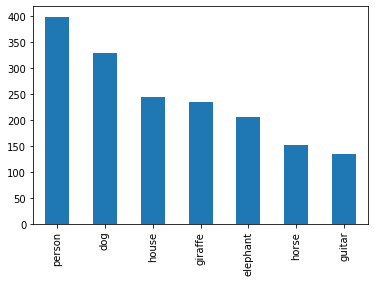

In [10]:
df["category"] = df["category"].replace(classes_dict)

df['category'].value_counts().plot.bar()

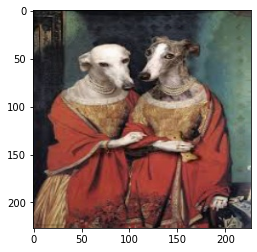

In [11]:
sample = random.choice(filenames)
image = load_img(train_dir+"/"+sample)
plt.imshow(image)

## Generator
- 모델 실행 시 OOM이 발생하여 IMG_SIZE를 (200, 200)으로 수정
- Cutmix를 활용하여 Data Augmentation시킴
    - input data의 특정 부분을 다른 input data와 결합시킴으로써, input data에 drop out을 취하는 효과를 얻음
    - 또한, 기존의 Cutout과 달리 label도 Mix가능함
    - 데이터 분류시 feature map의 더 많은 부분을 활성화 시킬 수 있음
    
- ImageDataGenerator에 옵션을 더 추가하여 돌릴 경우 너무 많이 데이터가 증가하여 속도가 느려짐

In [12]:
import imblearn

from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(random_state=42)

sampling_filenames, sampling_categories = undersample.fit_resample(df[['filename']], df[['category']])

In [13]:
sampling_filenames['category'] = sampling_categories

<AxesSubplot:>

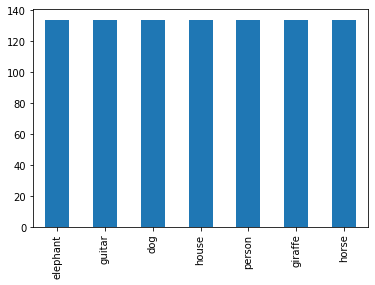

In [14]:
df_sampling = sampling_filenames.copy()
df_sampling['category'].value_counts().plot.bar()

In [15]:
from cutmix_keras import CutMixImageDataGenerator
from sklearn.model_selection import train_test_split

IMG_SIZE = 200
BATCH_SIZE = 20
CHANNEL_SIZE = 3

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df['category'])
train_df = train_df.reset_index(drop=True)
validation_df = validate_df.reset_index(drop=True)

In [17]:
train_df["category"].value_counts()

person      359
dog         296
house       220
giraffe     211
elephant    185
horse       136
guitar      121
Name: category, dtype: int64

In [18]:
validate_df["category"].value_counts()

person      40
dog         33
house       25
giraffe     24
elephant    20
horse       15
guitar      13
Name: category, dtype: int64

In [19]:
color_mode = "grayscale" if CHANNEL_SIZE == 1 else "rgb"

# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=(0.6, 1.4),
#     horizontal_flip=True,
#     vertical_flip=False,
# )


train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
)

train_generator1 = train_datagen.flow_from_dataframe(
    #train_df, 
    df,
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
    shuffle=True
)

train_generator2 = train_datagen.flow_from_dataframe(
    #train_df,
    df,
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
    shuffle=True
)

# !! Define CutMixImageDataGenerator !!
train_generator = CutMixImageDataGenerator(
    generator1=train_generator1,
    generator2=train_generator2,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1698 validated image filenames belonging to 7 classes.
Found 1698 validated image filenames belonging to 7 classes.


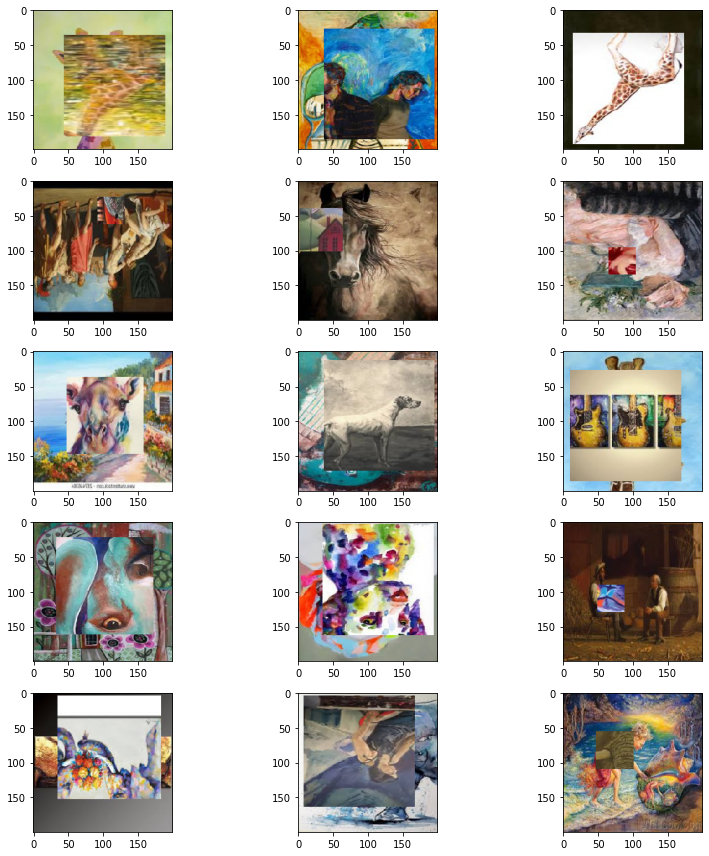

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(
    validation_df, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
)

Found 170 validated image filenames belonging to 7 classes.


## Model Settings

In [22]:
import os
from tensorflow.keras.applications import Xception  # (299 x 299)
from tensorflow.keras.applications import InceptionV3  # (299 x 299)
from tensorflow.keras.applications import InceptionResNetV2  # (299 x 299)
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import DenseNet201

In [23]:
conv_bases = (
    EfficientNetB4, Xception, DenseNet201#EfficientNetB5#, InceptionV3, InceptionResNetV2
)

## Model Definition
- 모델의 경우 ImageNet 데이터 셋과 유사하다고 판단하여 pretrained model을 활용
- art 데이터셋이므로 모든 파라미터를 재학습시킴
- FCN의 파라미터가 많다는 단점을 개선시키기 위해서 Gloabal Averager Pooling을 활용
- 또한, GAP 사용시 input size를 유동적으로 사용할 수 있음

In [24]:
# Define Get Model Function
def get_model(pretained_model, img_size, channel_size, initializer, regularizer, optimizer, dropout_rate, class_nb):
    model = models.Sequential()
    model.add(
        pretained_model(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, channel_size)
        )
    )
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        512,
        activation='relu',
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(class_nb, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    return model

# Define Get Step Function
def get_steps(num_data, batch_size):
    quotient, remainder = divmod(num_data, batch_size)
    return (quotient + 1) if remainder else quotient

## Callback
- ReduceLROnPlateau : 학습률이 개선되지 않을 때, 동적으로 학습률을 조정하여 Local Minima에 빠지는 현상을 갯너
- EarlyStopping : model의 성능 지표가 설정한 epoch동안 개선되지 않을 때 조기 종료하기 위해서 사용
- ModelCheckpoint : weight의 최고 성능(val_loss가 min)의 경우 weight를 저장하기 위해서 사용

In [25]:
# Define Get Callback Function
def get_callback_list(model_file_path, patience, verbose, system_print=False):
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=verbose,
        mode='min',
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience//2,
        verbose=verbose,
        mode='min',
        min_lr=1e-6,
    )
    model_chk = ModelCheckpoint(
        filepath=model_file_path,
        monitor='val_loss',
        verbose=verbose,
        save_best_only=True,
        mode='min',
    )
    callback_list = [early_stop, reduce_lr, model_chk]
    if system_print:
        callback_list.append(PrintSystemLogPerEpoch())
    return callback_list

In [27]:
# Constant Variables
LEARNING_RATE = 1e-4
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE)
EPOCHS = 10
INITIALIZER = 'he_normal'
REGULARIZER = regularizers.l2(1e-3)
DROPOUT_RATE = 0.5
PATIENCE = 6  # Patience Value For Early Stop
VERBOSE = 1  # Verbosity mode (2: No progress bar)
CLASS_NB = len(classes) # The number of Classes

## Training
- 하이퍼파라미터 튜닝을 위해서 모델을 하나씩 돌려봄

In [72]:
num = 2
pretained_model = conv_bases[2]
MODEL_SAVE_FOLDER_PATH = './models/'
model_name = str(num) + '_' + str(pretained_model).split()[1]
model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'

GET_CLASS_WEIGHTS = False

print(model_name)

# Get Model
model = get_model(
    pretained_model=pretained_model,
    img_size=IMG_SIZE,
    channel_size=CHANNEL_SIZE,
    initializer=INITIALIZER,
    regularizer=REGULARIZER,
    optimizer=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    class_nb=CLASS_NB,
)

# Train With Generators
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_generator.get_steps_per_epoch(),
    epochs=EPOCHS,
    verbose=VERBOSE,
    callbacks=get_callback_list(
        model_file_path=model_path,
        patience=PATIENCE,
        verbose=VERBOSE,
        system_print=True,
    ),
    validation_data=validation_generator,
    validation_steps=get_steps(validation_generator.samples, BATCH_SIZE),
    class_weight=class_weights_dict if GET_CLASS_WEIGHTS else None,
    shuffle=False,
)

2_DenseNet201


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Retraining
- 기존에 학습시킨 EfficientNetB4, Xception을 재학습시킴
    - LEARNING_RATE = 1e-4 -> 1e-5
    - UnderSampling 적용
    - rotation_range=15, # 추가
    - shear_range=0.1, # 추가
    - zoom_range=0.2, # 추가

In [28]:
historys = []

for i, conv_base in enumerate(conv_bases):

    num = i
    pretained_model = conv_base
    MODEL_SAVE_FOLDER_PATH = './models/'
    model_name = str(num) + '_' + str(pretained_model).split()[1]
    model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'
    
    GET_CLASS_WEIGHTS = False
    
    print(model_name)
    print("=====" * 10)

    # Get Model
    model = get_model(
        pretained_model=pretained_model,
        img_size=IMG_SIZE,
        channel_size=CHANNEL_SIZE,
        initializer=INITIALIZER,
        regularizer=REGULARIZER,
        optimizer=OPTIMIZER,
        dropout_rate=DROPOUT_RATE,
        class_nb=CLASS_NB,
    )

    model.load_weights(model_path)

    # Train With Generators
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch(),
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=get_callback_list(
            model_file_path=model_path,
            patience=PATIENCE,
            verbose=VERBOSE,
            system_print=True,
        ),
        validation_data=validation_generator,
        validation_steps=get_steps(validation_generator.samples, BATCH_SIZE),
        class_weight=class_weights_dict if GET_CLASS_WEIGHTS else None,
        shuffle=False,
    )
    
    historys.append(history)

    model_finish_path = MODEL_SAVE_FOLDER_PATH + model_name +'_finish.h5'
    model.save_weights(model_finish_path)

0_EfficientNetB4


C:\Users\bsy37\anaconda3\envs\tensorflow24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
* [Epoch 1] begins at 17:26:45.820542
85/85 [==============================] - 89s 766ms/step - loss: 1.0707 - acc: 0.8309 - val_loss: 1.0305 - val_acc: 0.7235

Epoch 00001: val_loss improved from inf to 1.03055, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 1] ends at 17:28:16.188898 | acc=0.8298, val_acc=0.7235
Epoch 2/10
* [Epoch 2] begins at 17:28:16.218600
85/85 [==============================] - 59s 694ms/step - loss: 1.0454 - acc: 0.8243 - val_loss: 0.4863 - val_acc: 0.9412

Epoch 00002: val_loss improved from 1.03055 to 0.48631, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 2] ends at 17:29:16.504430 | acc=0.8286, val_acc=0.9412
Epoch 3/10
* [Epoch 3] begins at 17:29:16.532453
85/85 [==============================] - 59s 695ms/step - loss: 1.0045 - acc: 0.8531 - val_loss: 0.4203 - val_acc: 0.9529

Epoch 00003: val_loss improved from 0.48631 to 0.42032, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 3] ends at 17:30:16.925262 | acc=0.8386, val_a

In [ ]:
hist = historys[1] 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['acc'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prediction
- 단일 모델 prediction과 앙상블 모델 preduiction 구현
- prediction 결과에 person이 많이 존재하는 것으로 보아, class imbalance가 있음을 유추할 수 있음
- class imbalance문제를 해결하기 위해 undersampling 적용

In [29]:
test_dir = os.path.join(base_dir, 'test')

test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    shuffle=False
)

Found 350 validated image filenames.


In [30]:
ENSEMBLE = True

model_paths = MODEL_SAVE_FOLDER_PATH

if ENSEMBLE:
    model_preds = []
    
    for i, conv_base in enumerate(conv_bases):
        
        num = i
        pretained_model = conv_base
        MODEL_SAVE_FOLDER_PATH = './models/'
        model_name = str(num) + '_' + str(pretained_model).split()[1]
        model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'

        # Get Model
        model = get_model(
            pretained_model=pretained_model,
            img_size=IMG_SIZE,
            channel_size=CHANNEL_SIZE,
            initializer=INITIALIZER,
            regularizer=REGULARIZER,
            optimizer=OPTIMIZER,
            dropout_rate=DROPOUT_RATE,
            class_nb=CLASS_NB,
        )

        model.load_weights(model_path)
        
        test_generator.reset()
        pred = model.predict_generator(
            test_generator, 
            #steps=np.ceil(nb_samples/batch_size),
            steps=get_steps(test_df.shape[0], BATCH_SIZE),
            verbose=VERBOSE)

        model_preds.append(pred)
        
pred_mean = np.mean(model_preds, axis=0)
test_df['category'] = np.argmax(pred_mean, axis=1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

C:\Users\bsy37\anaconda3\envs\tensorflow24\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 5s 121ms/step


In [30]:
if not ENSEMBLE:
    # Prediction
    print(model_path)
    model.load_weights(model_path)
    pred = model.predict_generator(
        test_generator, 
        #steps=np.ceil(nb_samples/batch_size),
        steps=get_steps(test_df.shape[0], BATCH_SIZE),
        verbose=VERBOSE)

    test_df['category'] = np.argmax(pred, axis=1)

    label_map = dict((v,k) for k,v in train_generator.class_indices.items())
    test_df['category'] = test_df['category'].replace(label_map)

./models/2_DenseNet201.h5


C:\Users\bsy37\anaconda3\envs\tensorflow24\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 7s 216ms/step


<AxesSubplot:>

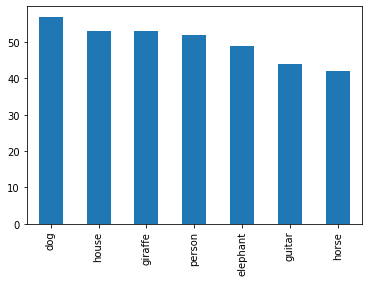

In [31]:
test_df['category'].value_counts().plot.bar()

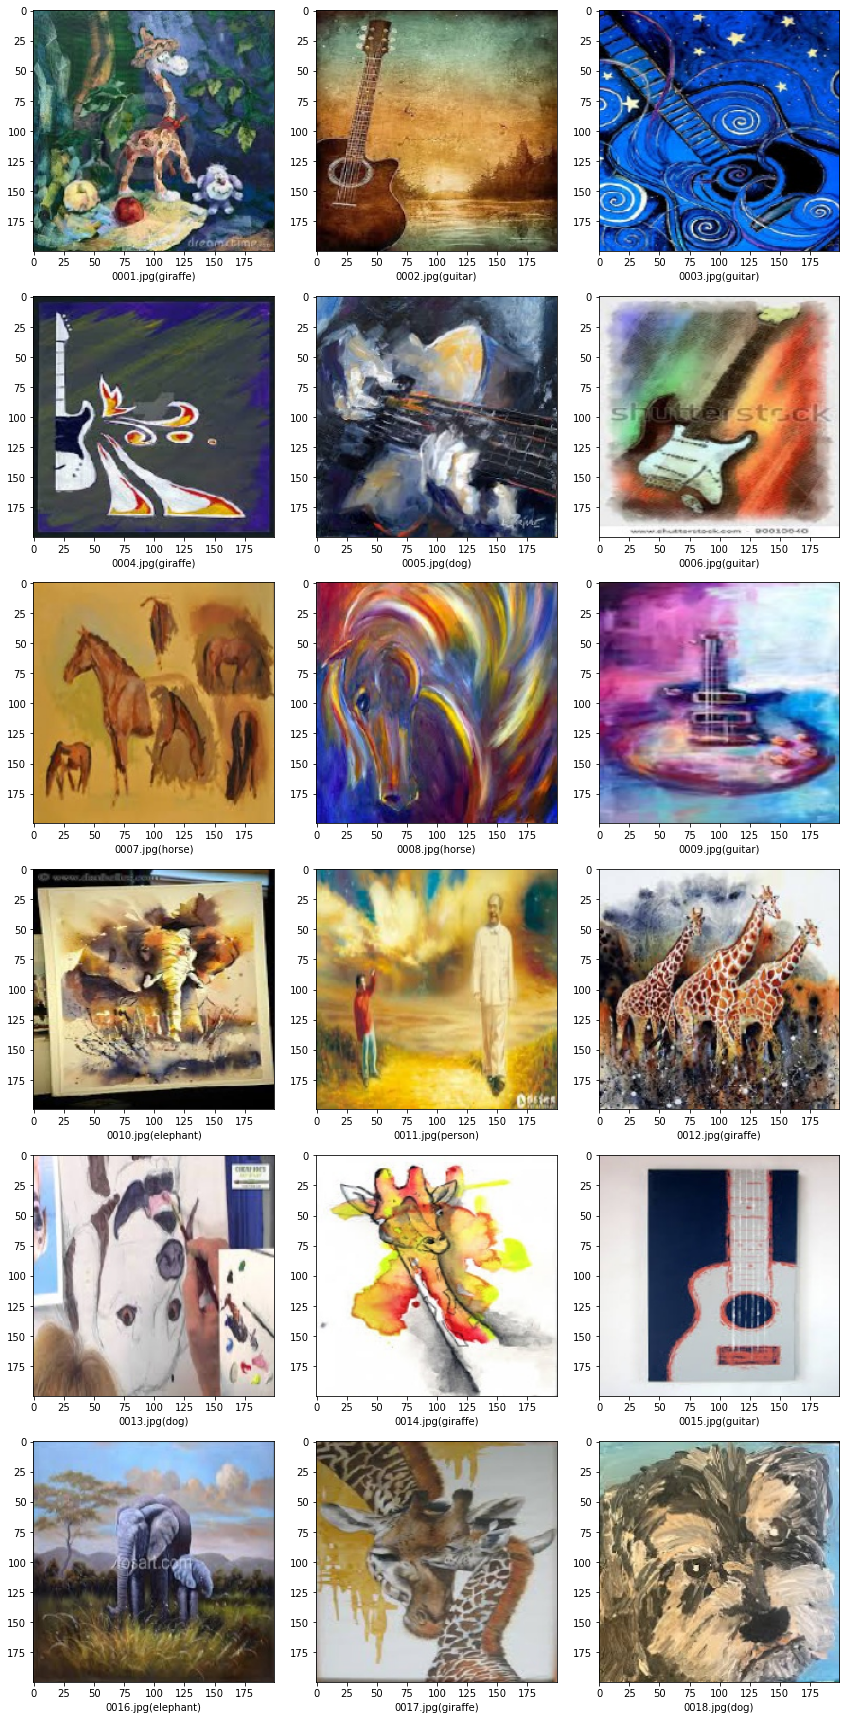

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_dir + "/" + filename, target_size=(IMG_SIZE,IMG_SIZE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [33]:
classes_test_dict = {c : i for i,c in enumerate(classes)}

In [34]:
test_df['category'] = test_df['category'].replace(classes_test_dict)

In [35]:
submission_df = test_df.copy()
submission_df['answer value'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=True)